In [1]:
!pip install segmentation_models_pytorch
import os
import cv2
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as utils

device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

  Obtaining dependency information for segmentation_models_pytorch from https://files.pythonhosted.org/packages/cb/70/4aac1b240b399b108ce58029ae54bc14497e1bbc275dfab8fd3c84c1e35d/segmentation_models_pytorch-0.3.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for timm==0.9.2 from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.7 MB/s eta 0:00:00
  Obtaining dependency information for munch from https://files.pythonhosted.org/packages/56/b3/7c69b37f03260a061883bec0e7b05be7117c1b1c85f5212c72c8c2bc3c8c/munch-4.0.0-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


cuda


In [2]:
#label class 
class_csv=pd.read_csv('/kaggle/input/semantic-drone-dataset/class_dict_seg.csv')
class_csv

name    r    g    b
0     unlabeled    0    0    0
1    paved-area  128   64  128
2          dirt  130   76    0
3         grass    0  102    0
4        gravel  112  103   87
5         water   28   42  168
6         rocks   48   41   30
7          pool    0   50   89
8    vegetation  107  142   35
9          roof   70   70   70
10         wall  102  102  156
11       window  254  228   12
12         door  254  148   12
13        fence  190  153  153
14   fence-pole  153  153  153
15       person  255   22   96
16          dog  102   51    0
17          car    9  143  150
18      bicycle  119   11   32
19         tree   51   51    0
20    bald-tree  190  250  190
21    ar-marker  112  150  146
22     obstacle    2  135  115
23  conflicting  255    0    0

In [3]:
#path
image_path='/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/'
mask_path='/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/'

In [4]:
#create list for getting file_name
images=[]
imgs=os.listdir(image_path)
for i in imgs:
    images.append(i)
    
print('size',len(images))
print('img',images[0:3])

size 400
img ['208.jpg', '473.jpg', '014.jpg']


In [5]:
#create file list
file_list=[]
for file in images:
    file_name=file.split('.')[0]
    file_list.append(file_name)
    
print('file_size:',len(file_list))
print('file_name:',file_list[0:3])

file_size: 400
file_name: ['208', '473', '014']


In [6]:
#create image_list and mask_list
image_list=[]
mask_list=[]
for file in file_list:
    image_file=file+'.jpg'
    mask_file=file+'.png'
    image_list.append(image_file)
    mask_list.append(mask_file)

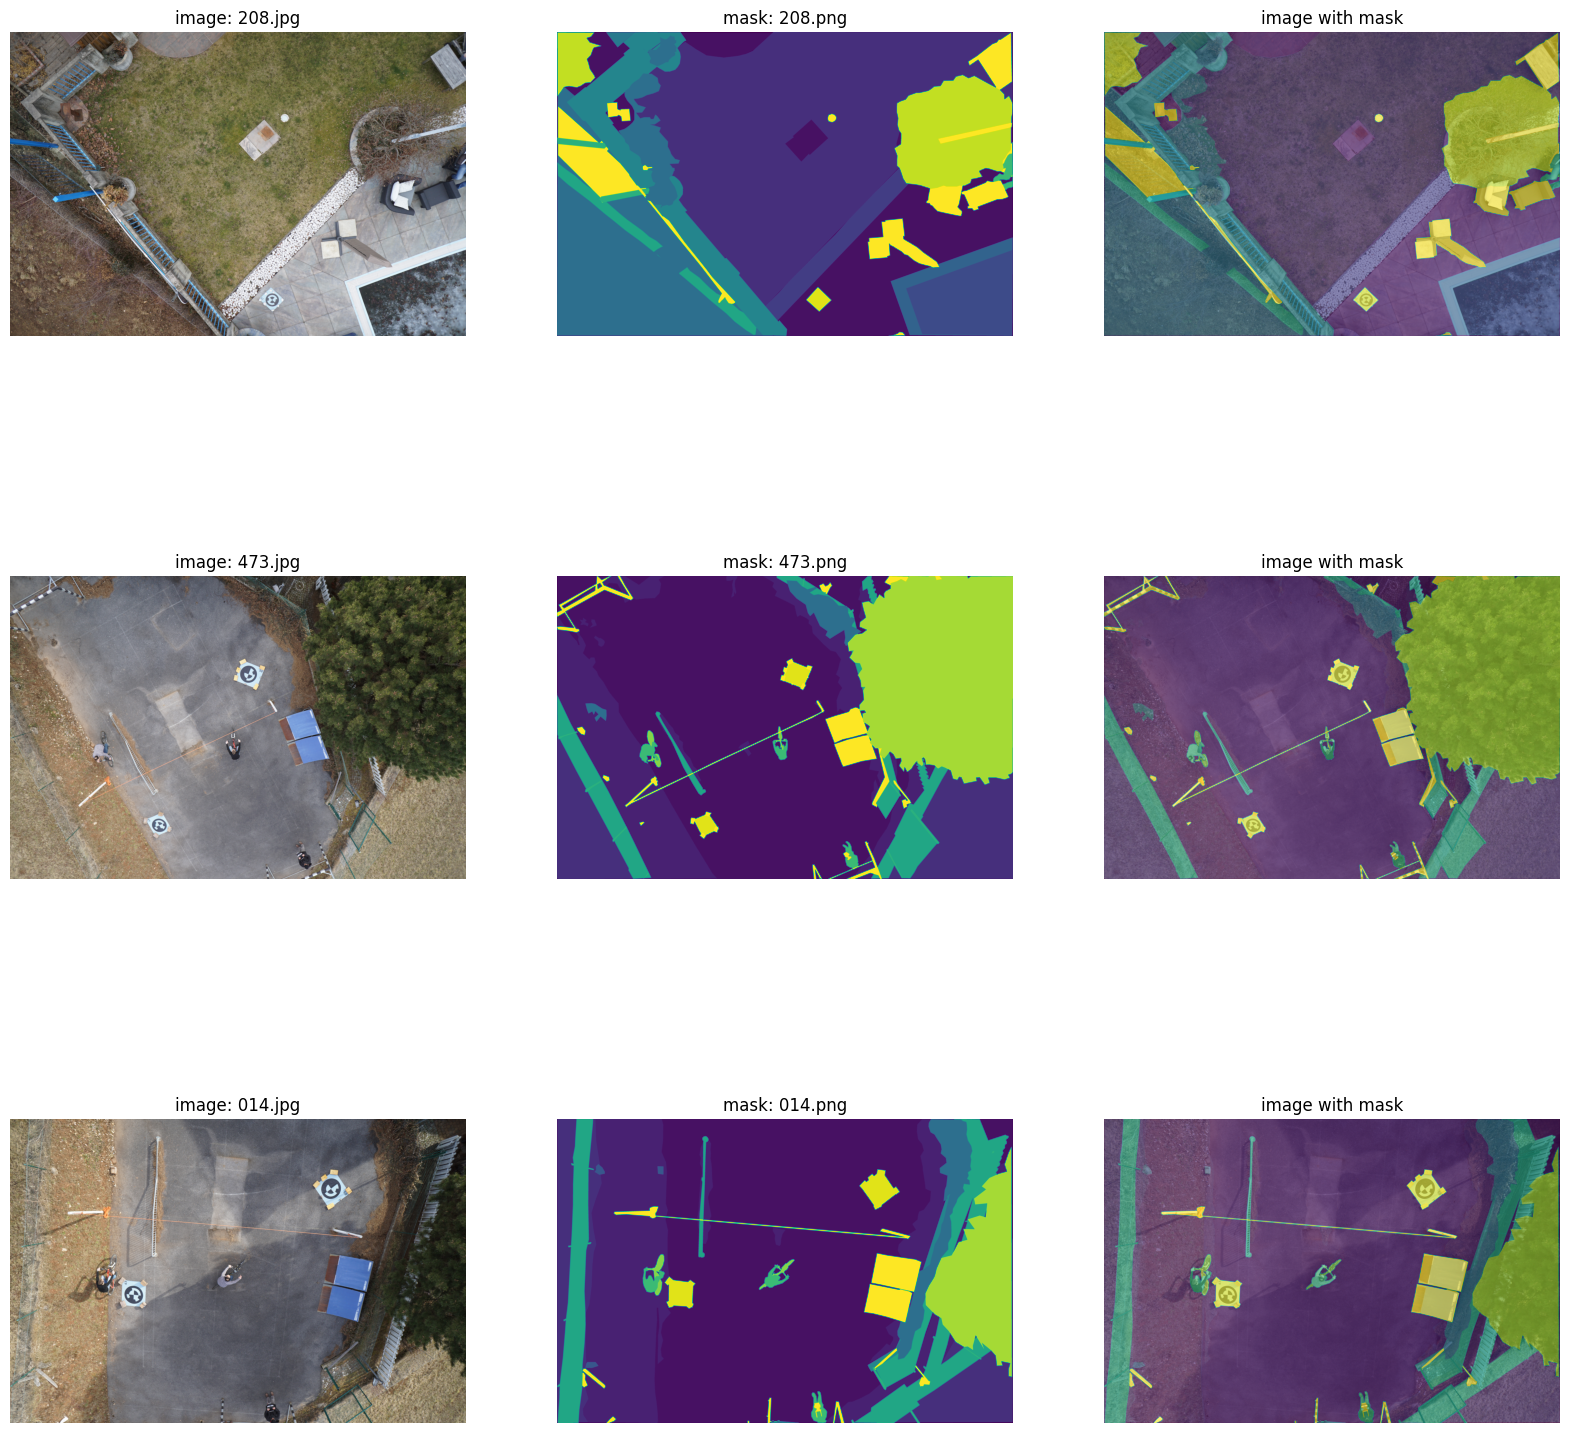

In [7]:
#view image, mask, image with mask
fig,ax=plt.subplots(nrows=3,ncols=3,figsize=(20,20))
for i in range(3):
    img=cv2.imread(image_path+image_list[i])
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    ax[i,0].set_title('image: '+image_list[i])
    ax[i,0].set_axis_off()
    ax[i,0].imshow(img)
    plt.axis(False)
    mask=cv2.imread(mask_path+mask_list[i])
    mask=cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
    ax[i,1].set_title('mask: '+mask_list[i])
    ax[i,1].set_axis_off()
    ax[i,1].imshow(mask)
    plt.axis(False)
    ax[i,2].set_title('image with mask')
    ax[i,2].set_axis_off()
    ax[i,2].imshow(img)
    ax[i,2].imshow(mask,alpha=0.6)
plt.show()

In [8]:
#train test split
train_val,test=train_test_split(file_list,test_size=0.1,random_state=1)
train,val=train_test_split(train_val,test_size=0.15,random_state=1)

print('train:',len(train))
print('val:',len(val))
print('test:',len(test))

train: 306
val: 54
test: 40


In [9]:
#dataset creation function
class drone_dataset(Dataset):
    def __init__(self,image_path,mask_path,X,size=(256,256)):
        super().__init__()
        self.image_path=image_path
        self.mask_path=mask_path
        self.X=X
        self.size=size
        self.image_transforms=transforms.Compose([transforms.ToTensor(),
                                                  transforms.Resize(self.size,antialias=True)])
        
    def __getitem__(self,idx):
        img=cv2.imread(self.image_path+self.X[idx]+'.jpg')
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        mask=cv2.imread(self.mask_path+self.X[idx]+'.png',cv2.IMREAD_GRAYSCALE)
        img=self.image_transforms(img)
        mask=torch.from_numpy(cv2.resize(mask,self.size)).long()
        return img,mask
        
    def __len__(self):
        return len(self.X)

In [10]:
#create dataset
train_dataset=drone_dataset(image_path,mask_path,train)
val_dataset=drone_dataset(image_path,mask_path,val)
test_dataset=drone_dataset(image_path,mask_path,test)

print('image.shape:',train_dataset[0][0].shape)
print('mask.shape:',train_dataset[0][1].shape)

image.shape: torch.Size([3, 256, 256])
mask.shape: torch.Size([256, 256])


In [11]:
#create dataloader
batch_size=5
train_dataloader=DataLoader(train_dataset,batch_size=batch_size,num_workers=4,shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=batch_size,num_workers=4,shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=batch_size,num_workers=4,shuffle=True)

imgs,msks=next(iter(train_dataloader))
print('imgs:',imgs.size())
print('msks:',msks.size())

imgs: torch.Size([5, 3, 256, 256])
msks: torch.Size([5, 256, 256])


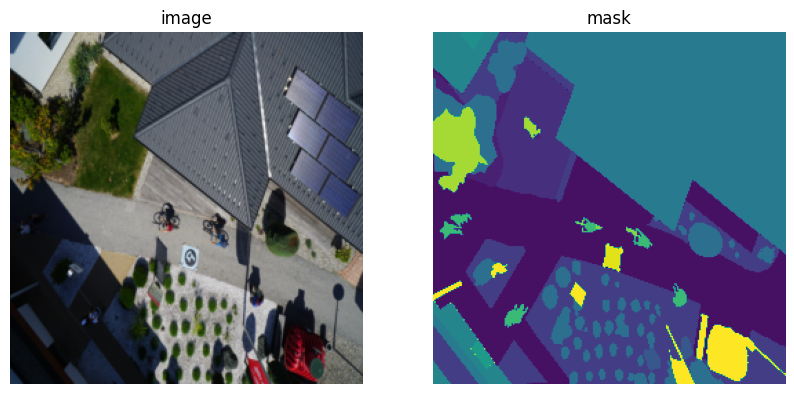

In [12]:
#view image and mask from dataloader
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(10,10))
for i in train_dataloader:
    img,mask=i
    ax[0].set_title('image')
    ax[0].set_axis_off()
    ax[0].imshow(img[0].permute(1,2,0))
    ax[1].set_title('mask')
    ax[1].set_axis_off()
    ax[1].imshow(mask[0])
    plt.show()
    break

In [13]:
#model settings
ENCODER="efficientnet-b4"
ENCODER_WEIGHTS="imagenet"

model=smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS,
    encoder_depth=5,
    decoder_channels=[256,128,64,32,16],
    classes=len(class_csv)-1, 
    activation=None,
)

model.to(device)
model

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:00<00:00, 283MB/s]


UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticS

In [14]:
#get preprocessing 
smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

functools.partial(<function preprocess_input at 0x7e58b6f67130>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [15]:
#training
criterion=nn.CrossEntropyLoss() 
optimizer=torch.optim.Adam([dict(params=model.parameters(),lr=0.0001)])
epochs=20
history={'train_loss':[],'valid_loss':[]}

for epoch in range(epochs):
    model.train()
    train_loss=0
    valid_loss=0
    for i,data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images,masks=data
        images=images.to(device)
        masks=masks.to(device)
        
        outputs=model(images)
        
        loss=criterion(outputs,masks)
        loss.backward()
        optimizer.step()
        
        train_loss+=loss.item()
    train_loss/=len(train_dataloader)
    history['train_loss'].append(train_loss)
    print(f'EPOCH: {epoch+1}, train_loss: {train_loss}')
    
    model.eval()
    with torch.no_grad():
        for i,data in enumerate(val_dataloader):
            images,masks=data
            images=images.to(device)
            masks=masks.to(device)
        
            outputs=model(images)
            loss=criterion(outputs,masks)
            
            valid_loss+=loss.item()
    valid_loss/=len(val_dataloader)
    history['valid_loss'].append(valid_loss)
    print(f'EPOCH: {epoch+1}, valid_loss: {valid_loss}')

EPOCH: 1, train_loss: 2.8366294714712326
EPOCH: 1, valid_loss: 2.5024137713692407
EPOCH: 2, train_loss: 2.150937303420036
EPOCH: 2, valid_loss: 1.966979135166515
EPOCH: 3, train_loss: 1.7366888503874502
EPOCH: 3, valid_loss: 1.6319501074877651
EPOCH: 4, train_loss: 1.5291956317040227
EPOCH: 4, valid_loss: 1.4544201764193447
EPOCH: 5, train_loss: 1.3696555975944764
EPOCH: 5, valid_loss: 1.3004695068706165
EPOCH: 6, train_loss: 1.268631778417095
EPOCH: 6, valid_loss: 1.201744090427052
EPOCH: 7, train_loss: 1.2002605815087595
EPOCH: 7, valid_loss: 1.118795010176572
EPOCH: 8, train_loss: 1.1425374707868021
EPOCH: 8, valid_loss: 1.0508648861538281
EPOCH: 9, train_loss: 1.0951528818376604
EPOCH: 9, valid_loss: 0.979342904957858
EPOCH: 10, train_loss: 1.0381062521088509
EPOCH: 10, valid_loss: 0.9486696991053495
EPOCH: 11, train_loss: 1.0067986288378317
EPOCH: 11, valid_loss: 0.9114086302843961
EPOCH: 12, train_loss: 0.942188415796526
EPOCH: 12, valid_loss: 0.8896626450798728
EPOCH: 13, train_

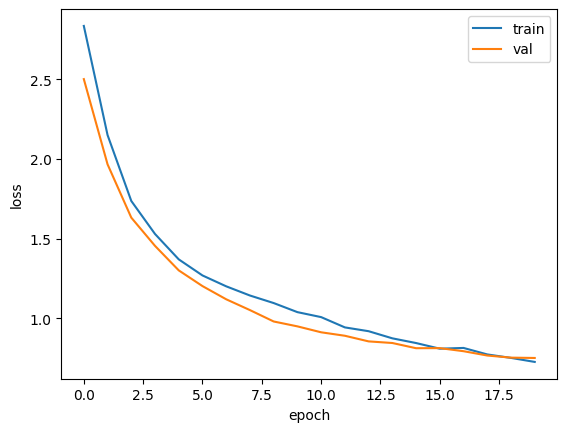

In [16]:
#view loss
plt.plot(history["train_loss"],label='train')
plt.plot(history["valid_loss"],label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

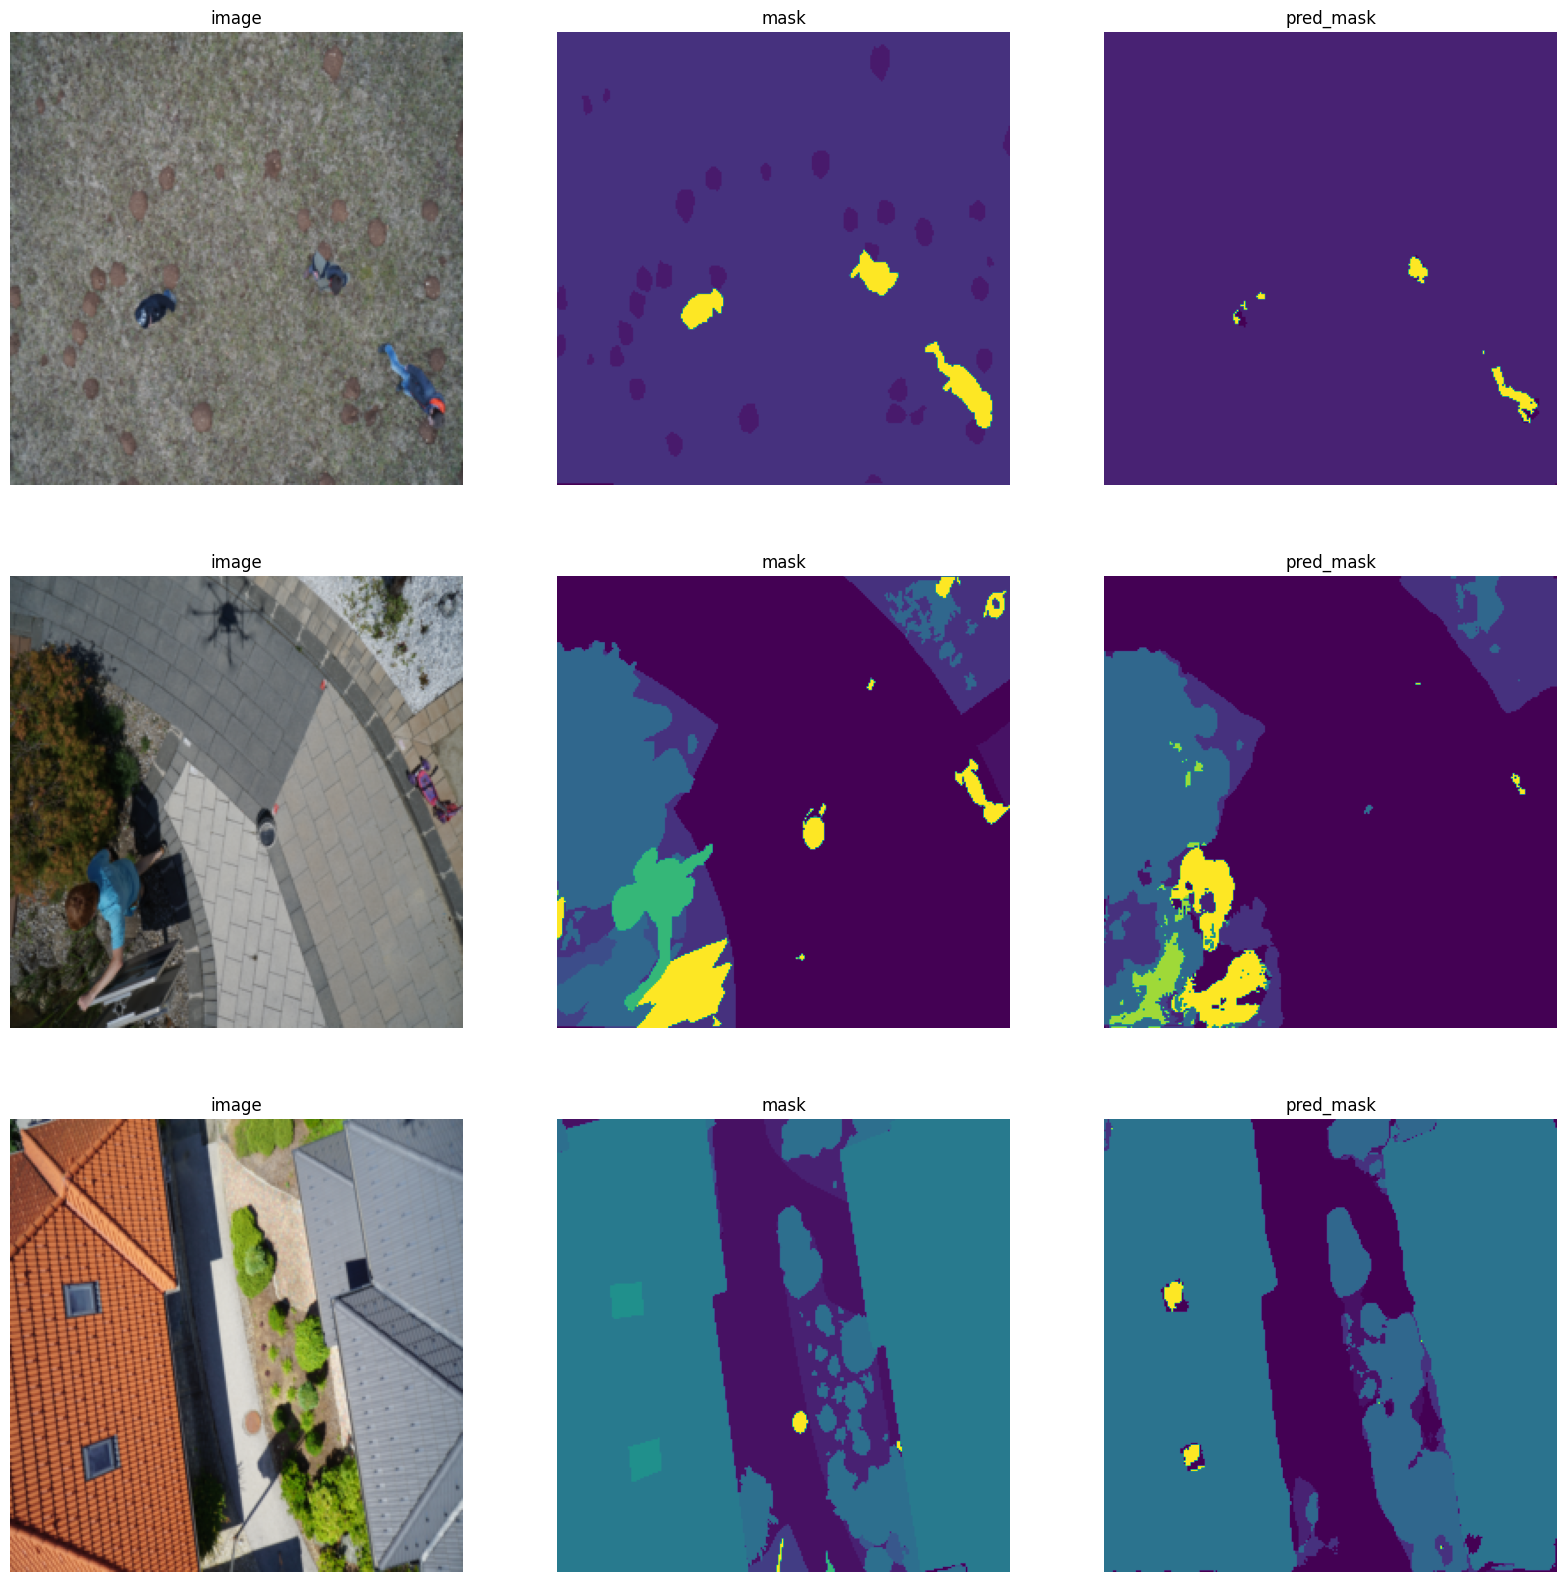

In [17]:
#evaluation
model.eval()
model.to(device)
fig,ax=plt.subplots(nrows=3,ncols=3,figsize=(20,20))
for i,data in enumerate(test_dataloader):
    images,masks=data
    images=images.to(device)
    masks=masks.to(device)
    with torch.no_grad():
        outputs=model(images)
        outputs=torch.argmax(outputs, dim=1)
    
    for i in range(3):
        ax[i,0].set_title('image')
        ax[i,0].set_axis_off()
        ax[i,0].imshow(images[i].cpu().permute(1,2,0))
        ax[i,1].set_title('mask')
        ax[i,1].set_axis_off()
        ax[i,1].imshow(masks[i].cpu())
        ax[i,2].set_title('pred_mask')
        ax[i,2].set_axis_off()
        ax[i,2].imshow(outputs[i].cpu())
    
    plt.show()
    break